In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.imputation import AddMissingIndicator
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from feature_engine.discretisation import DecisionTreeDiscretiser
from sklearn.model_selection import GroupShuffleSplit

from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
from sklearn.impute import SimpleImputer

#pip install xgboost==0.90
import xgboost as xgb
from featureSelection import get_best_features
from tqdm import tqdm
from pulearn import BaggingPuClassifier
import plotly.express as px
import shap

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1029676/2146214807.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/clean/master_los.csv', index_col=[0])

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_all.head()

,admissiondate,dischargedate,pat_mrn_id,viz_primary_payer_name,viz_disp_collapsed,viz_age,viz_ethnicity,viz_race,viz_race_collapsed,viz_language,viz_insurance,viz_service_collapsed,viz_ynhhs_sg2_service,viz_observed_mortality_yn,viz_drg,viz_admission_day,viz_discharged_day,viz_outcome_prolonged_los_yn,thro_door_to_admit_order_hrs,thro_admit_order_to_first_bed_hrs,thro_last_bed_to_ed_dept_hrs,thro_admit_order_to_ed_dept_hrs,thro_boarding_yn,thro_ed_arrival_time,thro_ed_arrival_day,thro_admit_or_obs_order_time,thro_admit_or_obs_order_day,thro_first_bed_assigned_time,thro_first_bed_assigned_day,thro_last_bed_assigned_time,thro_last_bed_assigned_day,thro_ed_departure_time,thro_ed_departure_day,summary_consult_count_all,summary_consult_count_unique_services,summary_pt_consult_order_yn,summary_pt_consult_order_time,summary_pt_consult_order_day,summary_sw_consult_order_yn,summary_sw_consult_order_time,summary_sw_consult_order_day,summary_first_edd_time,summary_first_edd_day,summary_first_edd_doc_time,summary_first_edd_doc_day,summary_first_edd_to_discharge_hrs,summary_first_edd_doc_to_discharge_hrs,summary_last_edd_time,summary_last_edd_day,summary_last_edd_doc_time,summary_last_edd_doc_day,summary_last_edd_to_discharge_hrs,summary_last_edd_doc_to_discharge_hrs,summary_first_rfd_status,summary_first_rfd_time,summary_first_rfd_day,summary_first_rfd_to_discharge_hrs,summary_last_rfd_status,summary_last_rfd_time,summary_last_rfd_day,summary_last_rfd_to_discharge_hrs,summary_total_hrs_nmr,summary_total_hrs_mrwb,summary_total_hrs_mrnb,rfd_first_nmr_start_day,rfd_first_nmr_start_time,rfd_first_mrnb_start_day,rfd_first_mrnb_start_time,rfd_first_mrwb_start_day,rfd_first_mrwb_start_time,rfd_first_nmr_to_discharge_hrs,rfd_first_mrnb_to_discharge_hrs,rfd_first_mrwb_to_discharge_hrs,rfd_last_nmr_effective_end_day,rfd_last_nmr_effective_end_time,rfd_last_mrnb_effective_end_day,rfd_last_mrnb_effective_end_time,rfd_last_mrwb_effective_end_day,rfd_last_mrwb_effective_end_time,rfd_last_nmr_to_discharge_hrs,rfd_last_mrnb_to_discharge_hrs,rfd_last_mrwb_to_discharge_hrs,con_max_consult_order_to_sign_any_hrs,con_avg_consult_order_to_sign_any_hrs,con_max_consult_note_to_sign_any_hrs,con_avg_consult_note_to_sign_any_hrs,con_signer_ym_provider_count,con_signer_nemg_provider_count,con_signer_community_provider_count,con_max_consult_order_to_sign_colon_and_rectal_hrs,con_max_consult_order_to_sign_diabetes_hrs,con_max_consult_order_to_sign_hematology_hrs,con_max_consult_order_to_sign_infectious_disease_hrs,con_max_consult_order_to_sign_lab_medicine_hrs,con_max_consult_order_to_sign_nephrology_hrs,con_max_consult_order_to_sign_oncology_hrs,con_max_consult_order_to_sign_picc_hrs,con_max_consult_order_to_sign_palliative_hrs,con_max_consult_order_to_sign_pulmonology_hrs,con_max_consult_order_to_sign_radiation_oncology_hrs,con_max_consult_order_to_sign_radiology_hrs,con_max_consult_order_to_sign_urology_hrs,con_max_consult_order_to_sign_cardiology_hrs,con_max_consult_order_to_sign_gastroenterology_hrs,con_max_consult_order_to_sign_hepatology_hrs,con_max_consult_order_to_sign_other_hrs,con_max_consult_order_to_sign_pharmacy_hrs,con_max_consult_order_to_sign_plastic_surgery_hrs,con_max_consult_order_to_sign_surgery_hrs,con_max_consult_order_to_sign_vascular_surgery_hrs,con_max_consult_order_to_sign_neurology_hrs,con_max_consult_order_to_sign_hospitalist_service_hrs,con_max_consult_order_to_sign_psychiatry_hrs,con_max_consult_order_to_sign_internal_medicine_hrs,con_max_consult_order_to_sign_neuro_oncology_hrs,con_max_consult_order_to_sign_neurosurgery_hrs,con_max_consult_order_to_sign_ophthalmology_hrs,con_max_consult_order_to_sign_orthopedics_hrs,con_max_consult_order_to_sign_physical_medicine_and_rehabilitation_hrs,con_max_consult_order_to_sign_podiatry_hrs,con_max_consult_order_to_sign_dermatology_hrs,con_max_consult_order_to_sign_geriatrics_hrs,con_max_consult_order_to_sign_addiction_medicine_hrs,con_max_consult_order_to_sign_otolaryngology_ent_hrs,con_max_consult

In [5]:
df_all.shape

(13205, 336)

In [6]:
df_all["viz_disp_collapsed"].value_counts()

viz_disp_collapsed
Other    8346
Home     4859
Name: count, dtype: int64

In [7]:
df_all["thro_boarding_yn"].value_counts()

thro_boarding_yn
1.0    6895
0.0    5585
Name: count, dtype: int64

In [8]:
#Filter for home patients
#df_home = df_all.copy()
#df_home = df_all[df_all["viz_disp_collapsed"] == "Home"].copy()
df_home = df_all[df_all["thro_boarding_yn"] == 0].copy()

In [9]:
#df_home.shape

In [10]:
# aitc_features.xlsx includes all the feature names and corresponding types
features_los = pd.read_excel('/gpfs/milgram/project/rtaylor/imc33/data/clean/features_los.xlsx')

# Features that are divided into 5 types to conduct data preprocessing
# 1. drop: features that need to be dropped
drop_list = features_los[features_los['type'] == 'drop']['col_name'].tolist()

# 2. category: features that are already categorical and need to be OneHotEncoding (add missing value indicator, impute missing by adding 'missing' category)
category_list = features_los[features_los['type'] == 'category']['col_name'].tolist()

# 3. binary: features that are binary and need to be converted to categorical (add missing value indicator / prefer: fill missing with 0)
binary_list = features_los[features_los['type'] == 'binary']['col_name'].tolist()

# 4. continuous: features that are continous/numerical variables, need outlier handling and normalization (add missing value indicator, fill missing with median)
continuous_list = features_los[features_los['type'] == 'continuous']['col_name'].tolist()

# 5. discrete: features that are discrete/numerical variables, need to be discretized (fill missing with 0)
discrete_list = features_los[features_los['type'] == 'discrete']['col_name'].tolist()

In [11]:
# Identify variables with infinite values
variables_with_inf = df_home.columns[df_home.isin([np.inf, -np.inf]).any()]

# Handle infinite values (e.g., replace with NaN)
df_home[variables_with_inf] = df_home[variables_with_inf].replace([np.inf, -np.inf], np.nan)

In [12]:
# Split into X, y
X = df_home.drop(['viz_outcome_prolonged_los_yn'], axis=1)
y = df_home['viz_outcome_prolonged_los_yn']

In [13]:
# Convert variables to categorical
X[binary_list] = X[binary_list].astype('category')
X[category_list] = X[category_list].astype('category')

In [14]:
# Drop features that have >= 99% missing values And features in drop list
missing_pct = X.isnull().mean() * 100
cols_to_drop = missing_pct[missing_pct >= 99].index.tolist()
#final_drop_list = list(set(drop_list + cols_to_drop))
#X_1b = X_1b.drop(columns=final_drop_list)
#X_1b = X_1b.reset_index(drop=True)
#y_1b = y_1b.reset_index(drop=True)

In [15]:
missing_pct.reset_index()

,index,0
0,admissiondate,0.000000
1,dischargedate,0.000000
2,pat_mrn_id,0.000000
3,viz_primary_payer_name,1.880036
4,viz_disp_collapsed,0.000000
...,...,...
330,census_daily_inpt_count,1.611459
331,ed_arrival_time,0.000000
332,ed_arrival_hour,0.000000
333,ed_arrival_date,0.000000


In [16]:
# We do NOT want to drop these
#cols_to_drop
#only these
drop_list

['admissiondate',
 'ed_arrival_time',
 'ed_arrival_hour',
 'ed_arrival_date',
 'dischargedate']

In [17]:
X = X.drop(columns=drop_list)
X = X.reset_index()
y = y.reset_index()

In [18]:
# Split the data by group shuffle split on 'PAT_MRN_ID' into train set and validation set
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

train_ix, val_ix = next(gss.split(X, y, groups=X['pat_mrn_id']))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_val = X.loc[val_ix]
y_val = y.loc[val_ix]

# Drop 'PAT_MRN_ID' and set 'PAT_ENC_CSN_ID' as index
X_train = X_train.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')
X_val = X_val.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')

In [19]:

# Update feature preprocessing pipeline
feature_preprocess_pipeline = Pipeline(steps=[

    # Missing value indicator for categoricals and continuous variables
    ('missing_indicator', AddMissingIndicator(variables=category_list + continuous_list)),

    # Missing value imputation
    # Impute missing values with 0 for discrete variables
    ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=discrete_list + continuous_list)),

  
    # Impute missing values with adding 'missing' category for categorical variables 
   ('categorical_imputer', CategoricalImputer(variables=category_list)),

    # Impute missing values with 0 for binary variables 
    ('binary_imputer', CategoricalImputer(fill_value='0', variables=binary_list)),

    
    # Rare encoding for categorical variables
    ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=5, max_n_categories=10, variables=category_list)),

    # OneHotEncoding for categoricals
    ('one_hot_category', OneHotEncoder(variables=category_list)),

    # Outlier handling & normalization for continous variables
   #('outlier_handling', Winsorizer(capping_method='gaussian', tail='right', fold=3, variables=continuous_list)),
    #todo: 

   ('normalize', SklearnTransformerWrapper(MinMaxScaler(feature_range=(0, 1)), variables=continuous_list)),

    # discretize for discrete variables
   #('discretize', DecisionTreeDiscretiser(cv=3, scoring='roc_auc', regression=False, random_state=42, variables=discrete_list))
    #todo:
    
])  # Apply the pipeline

In [20]:
# Apply the pipeline
X_train_preprocessed = feature_preprocess_pipeline.fit_transform(X_train, y_train)
X_val_preprocessed = feature_preprocess_pipeline.transform(X_val)

In [21]:
X_train_preprocessed.shape

(4489, 856)

In [22]:
X_train_preprocessed.to_csv('train_preprocessed.csv')
X_val_preprocessed.to_csv('val_preprocessed.csv')

In [23]:
# 1st Feature Selection pipeline
feature_selection_pipeline = Pipeline(steps=[

        ('drop_constant', DropConstantFeatures(tol=0.99)),

        ('drop_duplicates', DropDuplicateFeatures()),

        ('correlated_features', SmartCorrelatedSelection(
        method='pearson',
        threshold=0.9,
        selection_method='model_performance',
        estimator=xgb.XGBClassifier(random_state=0)
        ))
])

In [24]:
# Apply the pipeline
X_train_selected = feature_selection_pipeline.fit_transform(X_train_preprocessed, y_train['viz_outcome_prolonged_los_yn'])
X_val_selected = feature_selection_pipeline.transform(X_val_preprocessed)

In [25]:
X_train_selected.to_csv('train_initial_selected.csv')
X_val_selected.to_csv('val_initial_selected.csv')

In [26]:
X_train_preprocessed.shape

(4489, 856)

In [27]:
X_train_selected.shape

(4489, 401)

In [28]:
# Read files
X_train_selected = pd.read_csv('train_initial_selected.csv')
X_val_selected = pd.read_csv('val_initial_selected.csv')

In [29]:
train_selected = X_train_selected.merge(y_train, on='pat_enc_csn_id', how='left')
val_selected = X_val_selected.merge(y_val, on='pat_enc_csn_id', how='left')

In [30]:
train_selected = train_selected.set_index('pat_enc_csn_id')
val__selected = val_selected.set_index('pat_enc_csn_id')

In [31]:
y_train

,pat_enc_csn_id,viz_outcome_prolonged_los_yn
2,307012837,1
3,307031936,0
4,307170208,1
6,307527417,1
7,307723350,1
...,...,...
5577,343928227,0
5579,343872682,0
5580,343962942,0
5582,343981093,0


In [32]:
# Top 20 features - training set
#get_best_features(num_feats = 20, df = train_selected, df_name = 'train', target = 'viz_outcome_prolonged_los_yn')

In [33]:
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8))
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf', XGBClassifier(random_state=8))])

In [34]:
#!pip install scikit-optimize

In [35]:
#hyperparameter values
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [36]:
y_train = y_train.set_index('pat_enc_csn_id')

In [37]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(random_state=8))]),
              n_iter=10, random_state=8, scoring='roc_auc',
              search_spaces={'clf__colsample_bylevel': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'clf__colsample_bynode': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'clf__co...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [38]:
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['viz_primary_payer_name',
                                     'viz_disp_collapsed', 'viz_ethnicity',
                                     'viz_race', 'viz_race_collapsed',
                                     'viz_language', 'viz_insurance',
                                     'viz_service_collapsed',
                                     'viz_ynhhs_sg2_service',
                                     'viz_observed_mortality_yn', 'viz_drg',
                                     'viz_admission_day', 'viz_discharged_day',
                                     'thro_boarding_yn', 'thro_ed_arrival_time',
                                     'thro_ed_...
                                     'summary_sw_consult_order_time',
                                     'summary_sw_consult_order_day', ...])),
                ('clf',
                 XGBClassifier(colsample_bylevel=0.7750018497221565,
                               colsample_bynode=0.5614437441596264,
                               colsample_bytree=0.9126202065825759,
                               gamma=8.289497472648083,
                               learning_rate=0.4299244814327041, max_depth=6,
                               random_state=8, reg_alpha=2.784887532399771,
                               reg_lambda=1.67027558902639,
                               subsample=0.5966102807384807))])

In [39]:
opt.best_score_

0.8726371684103188

In [40]:
y_val = y_val.set_index('pat_enc_csn_id')

In [41]:
opt.score(X_val, y_val)

0.8670337969877703

In [42]:
opt.predict(X_val)

array([1, 1, 1, ..., 0, 0, 0])

In [43]:
opt.predict_proba(X_val)

array([[0.1521951 , 0.8478049 ],
       [0.14399958, 0.8560004 ],
       [0.48627263, 0.51372737],
       ...,
       [0.8763155 , 0.12368451],
       [0.9465841 , 0.05341592],
       [0.95548695, 0.04451304]], dtype=float32)

In [44]:
opt.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['viz_primary_payer_name', 'viz_disp_collapsed',
                      'viz_ethnicity', 'viz_race', 'viz_race_collapsed',
                      'viz_language', 'viz_insurance', 'viz_service_collapsed',
                      'viz_ynhhs_sg2_service', 'viz_observed_mortality_yn',
                      'viz_drg', 'viz_admission_day', 'viz_discharged_day',
                      'thro_boarding_yn', 'thro_ed_arrival_time',
                      'thro_ed_arrival_day', 'thro_admit_or...
                      'thro_first_bed_assigned_time',
                      'thro_first_bed_assigned_day',
                      'thro_last_bed_assigned_time', 'thro_last_bed_assigned_day',
                      'thro_ed_departure_time', 'thro_ed_departure_day',
                      'summary_pt_consult_order_yn',
                      'summary_pt_consult_order_time',
                      'summary_pt_consult_order_day',
                      'summary_sw_consult_order_yn',
     

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

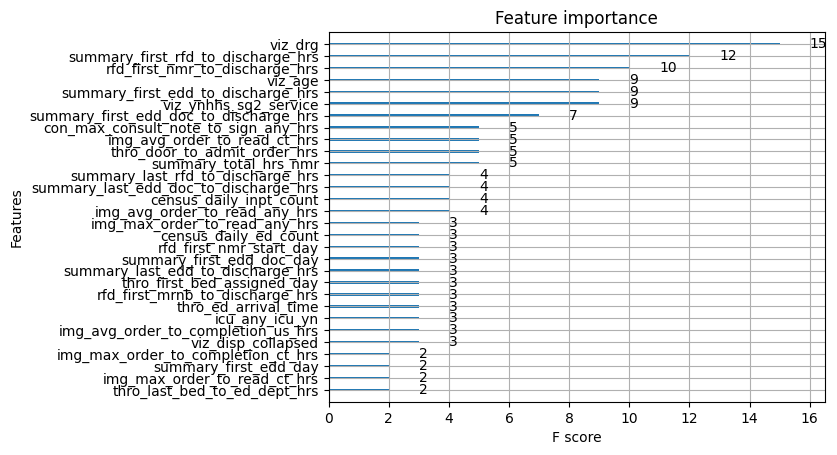

In [45]:
#https://www.youtube.com/watch?v=aLOQD66Sj0g&ab_channel=LianneandJustin
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model, max_num_features=30)

In [ ]:
#use SHAP value plot to visualize categorical s